# Przewidywanie Ceny Złota z wykorzystaniem Sztucznej Inteligencji

Ten notebook przedstawia proces przewidywania cen złota przy użyciu metod uczenia maszynowego.

## 1. Importowanie bibliotek

W tej sekcji importujemy niezbędne biblioteki do analizy danych i uczenia maszynowego.

In [13]:
# Importowanie bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline

## 2. Tworzenie zbioru danych

Pobieramy historyczne dane cen złota używając biblioteki yfinance, która umożliwia łatwe pobieranie danych giełdowych.

In [14]:
# Pobieranie danych historycznych cen złota
# Symbol GC=F oznacza kontrakty futures na złoto
start_date = '2010-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

gold_data = yf.download('GC=F', start=start_date, end=end_date)
gold_data.reset_index(inplace=True)

print(f"Pobrano dane od {gold_data['Date'].min()} do {gold_data['Date'].max()}")
gold_data.head()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['GC=F']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


Pobrano dane od NaT do NaT


Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,GC=F,GC=F,GC=F,GC=F,GC=F,GC=F


In [4]:
# Sprawdzamy podstawowe informacje o zbiorze danych
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   (Date, )           0 non-null      datetime64[ns]
 1   (Adj Close, GC=F)  0 non-null      float64       
 2   (Close, GC=F)      0 non-null      float64       
 3   (High, GC=F)       0 non-null      float64       
 4   (Low, GC=F)        0 non-null      float64       
 5   (Open, GC=F)       0 non-null      float64       
 6   (Volume, GC=F)     0 non-null      float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 132.0 bytes


In [5]:
# Sprawdzamy czy występują brakujące wartości
print(f"Liczba brakujących wartości w każdej kolumnie:\n{gold_data.isnull().sum()}")

Liczba brakujących wartości w każdej kolumnie:
Price      Ticker
Date                 0
Adj Close  GC=F      0
Close      GC=F      0
High       GC=F      0
Low        GC=F      0
Open       GC=F      0
Volume     GC=F      0
dtype: int64


## 3. Analiza danych

W tej sekcji przeprowadzimy eksploracyjną analizę danych, w tym wizualizację trendów, sezonowości i korelacji.

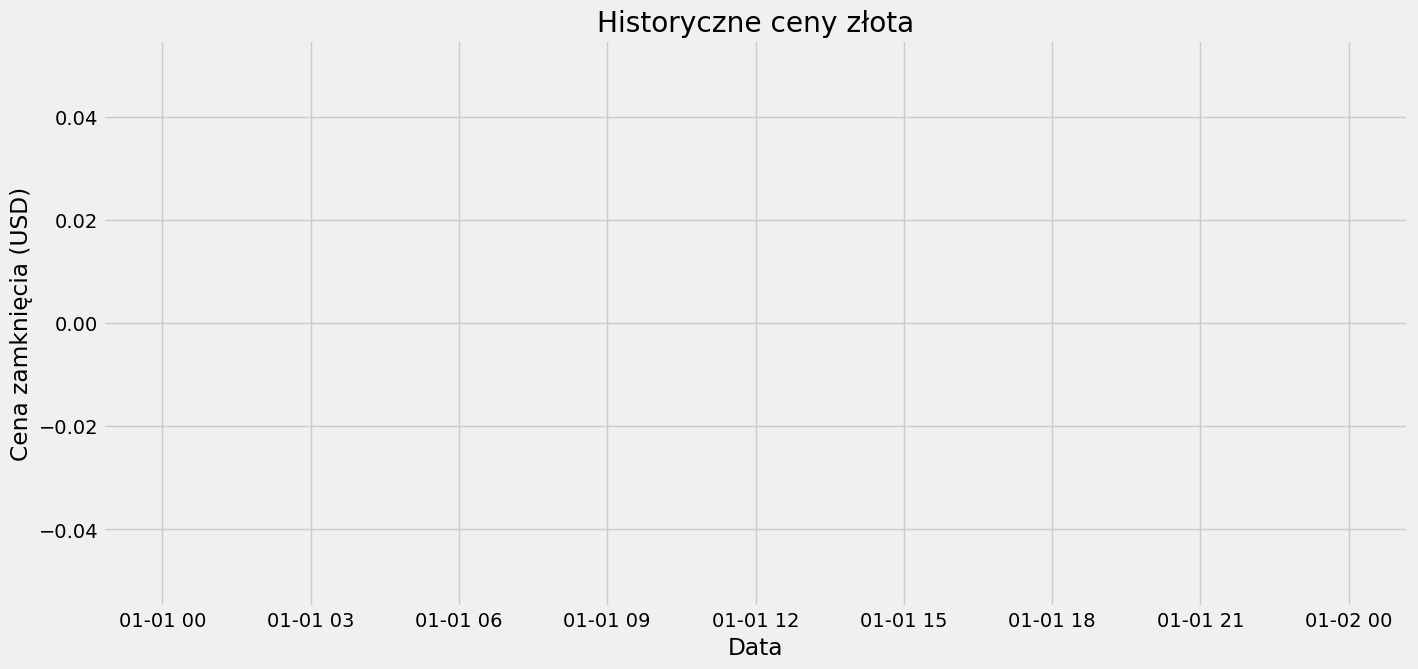

In [6]:
# Wizualizacja ceny zamknięcia złota na przestrzeni czasu
plt.figure(figsize=(15, 7))
plt.title('Historyczne ceny złota')
plt.plot(gold_data['Date'], gold_data['Close'])
plt.xlabel('Data')
plt.ylabel('Cena zamknięcia (USD)')
plt.grid(True)
plt.show()

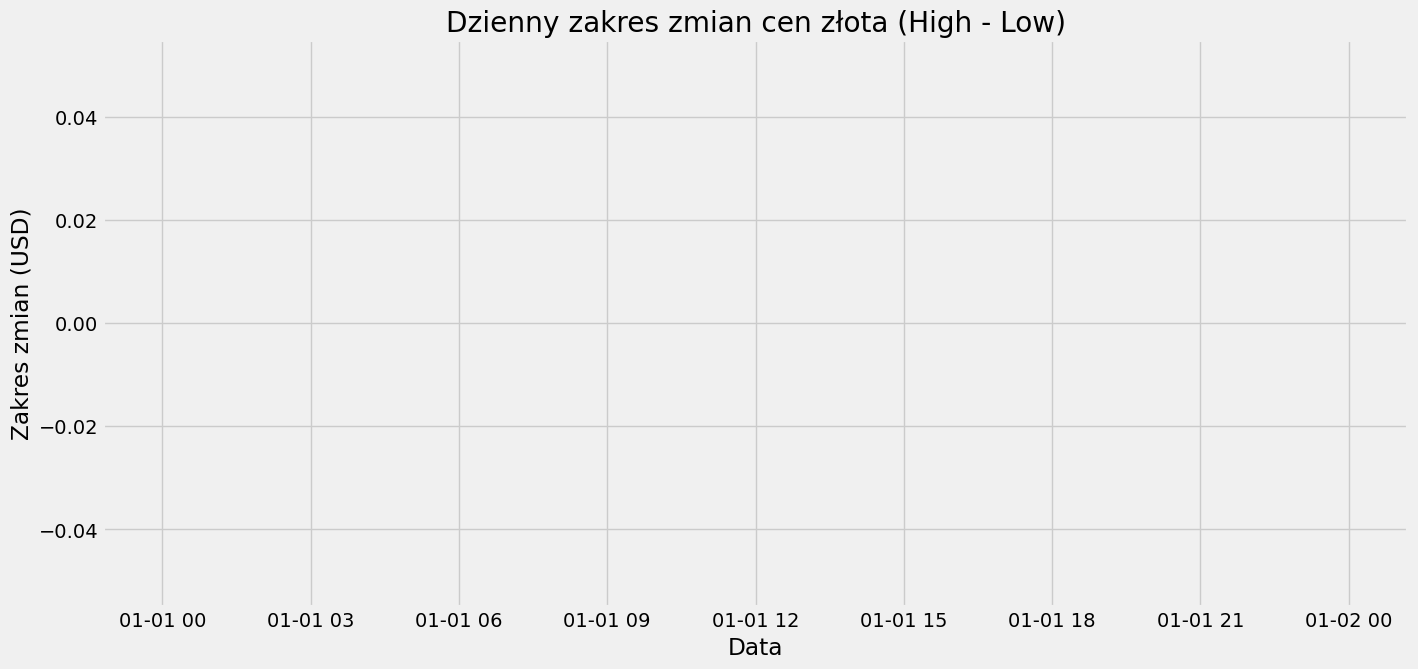

In [7]:
# Analiza zmienności cen złota
plt.figure(figsize=(15, 7))
plt.title('Dzienny zakres zmian cen złota (High - Low)')
plt.plot(gold_data['Date'], gold_data['High'] - gold_data['Low'], color='red')
plt.xlabel('Data')
plt.ylabel('Zakres zmian (USD)')
plt.grid(True)
plt.show()

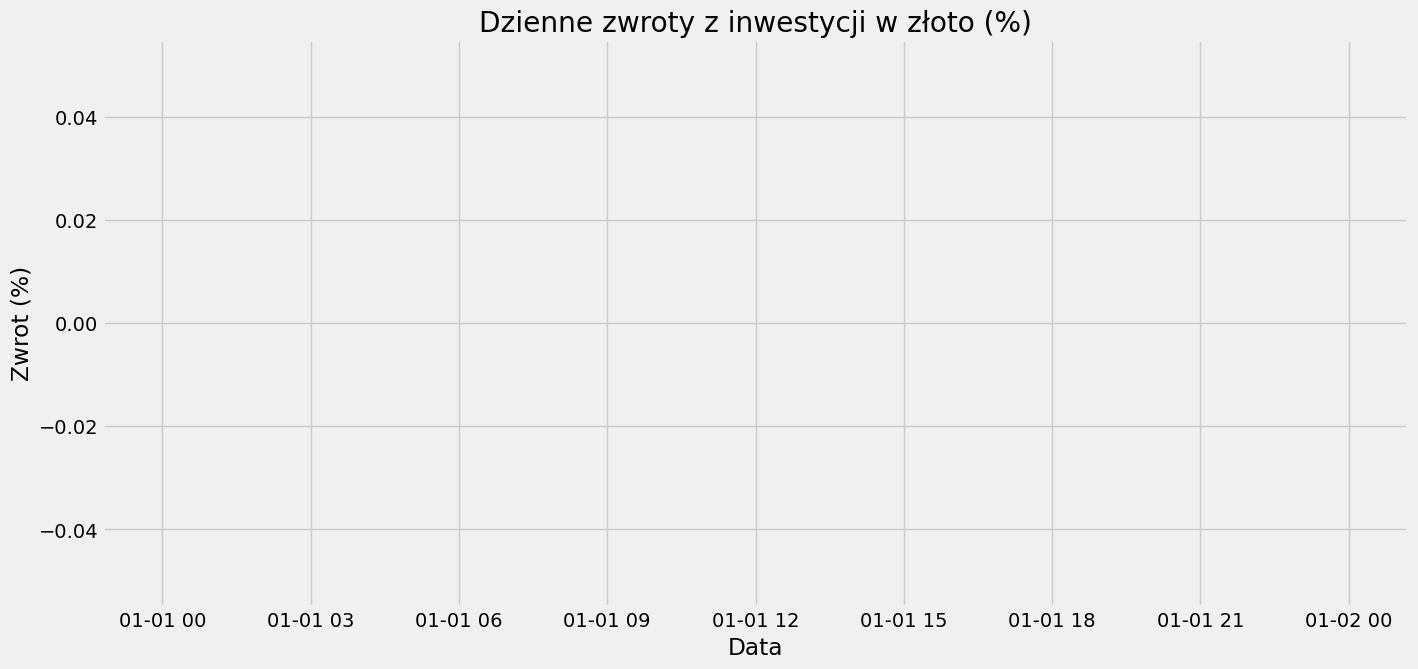

In [8]:
# Obliczanie dziennych zwrotów
gold_data['Return'] = gold_data['Close'].pct_change() * 100

# Wykres dziennych zwrotów
plt.figure(figsize=(15, 7))
plt.title('Dzienne zwroty z inwestycji w złoto (%)')
plt.plot(gold_data['Date'], gold_data['Return'], color='green')
plt.xlabel('Data')
plt.ylabel('Zwrot (%)')
plt.grid(True)
plt.show()

In [9]:
# Statystyki opisowe
descriptive_stats = gold_data[['Open', 'High', 'Low', 'Close', 'Return']].describe()
print(descriptive_stats)

Price  Open High  Low Close Return
Ticker GC=F GC=F GC=F  GC=F       
count   0.0  0.0  0.0   0.0    0.0
mean    NaN  NaN  NaN   NaN    NaN
std     NaN  NaN  NaN   NaN    NaN
min     NaN  NaN  NaN   NaN    NaN
25%     NaN  NaN  NaN   NaN    NaN
50%     NaN  NaN  NaN   NaN    NaN
75%     NaN  NaN  NaN   NaN    NaN
max     NaN  NaN  NaN   NaN    NaN


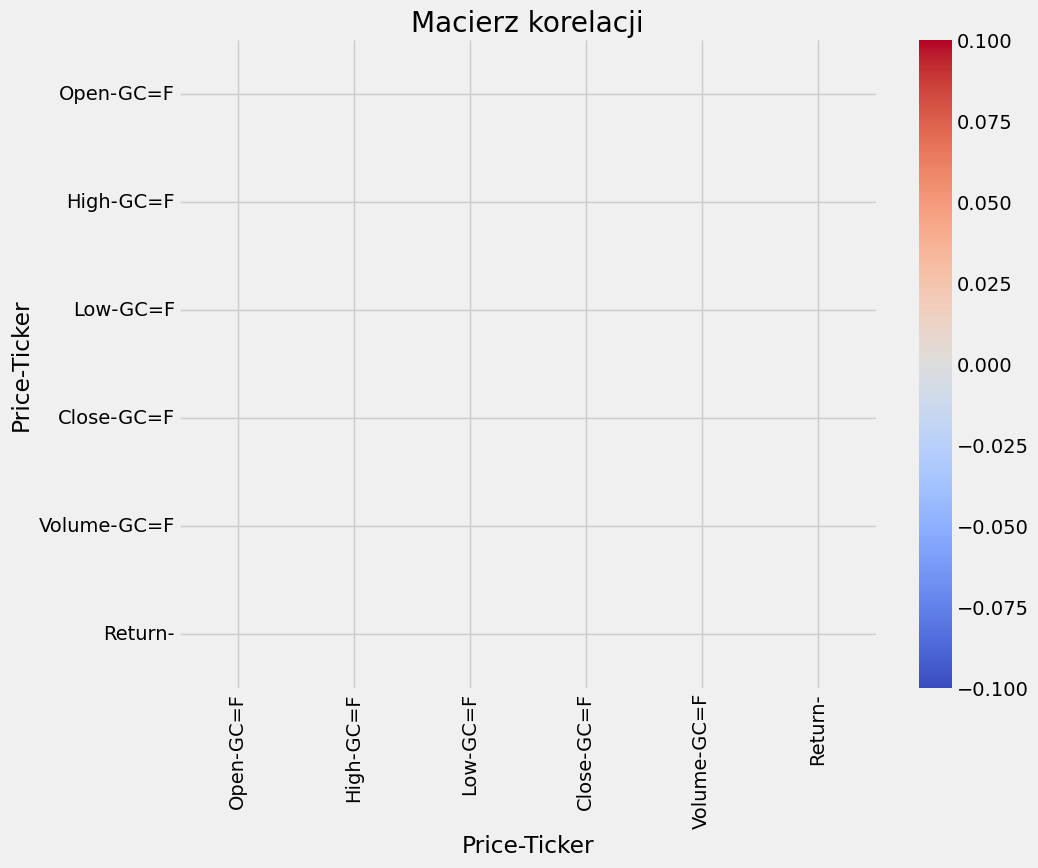

In [10]:
# Analiza korelacji
correlation_matrix = gold_data[['Open', 'High', 'Low', 'Close', 'Volume', 'Return']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji')
plt.show()

## 4. Przygotowanie danych

W tej sekcji przygotujemy dane do trenowania modelu, w tym normalizację i podział na zbiory treningowy i testowy.

In [11]:
# Wybieramy tylko kolumnę z ceną zamknięcia do modelowania
data = gold_data.filter(['Close'])
dataset = data.values

# Ustalamy rozmiar zbiorów treningowego i testowego
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

# Dzielimy dane
train_data = dataset[0:train_size, :]
test_data = dataset[train_size:len(dataset), :]

print(f"Rozmiar zbioru treningowego: {len(train_data)}")
print(f"Rozmiar zbioru testowego: {len(test_data)}")

Rozmiar zbioru treningowego: 0
Rozmiar zbioru testowego: 0


In [12]:
# Wybieramy tylko kolumnę z ceną zamknięcia do modelowania
data = gold_data[['Close']]  # Użycie bezpośredniej indeksacji zamiast filter()
dataset = data.values

# Ustalamy rozmiar zbiorów treningowego i testowego
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

# Dzielimy dane
train_data = dataset[0:train_size, :]
test_data = dataset[train_size:len(dataset), :]

print(f"Kształt train_data: {train_data.shape}")
print(f"Kształt test_data: {test_data.shape}")

# Normalizacja danych
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Pozostała część kodu pozostaje bez zmian
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60
X_train, y_train = create_sequences(scaled_train_data, time_steps)
X_test, y_test = create_sequences(scaled_test_data, time_steps)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Kształt X_train: {X_train.shape}")
print(f"Kształt y_train: {y_train.shape}")
print(f"Kształt X_test: {X_test.shape}")
print(f"Kształt y_test: {y_test.shape}")

Kształt train_data: (0, 1)
Kształt test_data: (0, 1)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

## 5. Tworzenie modelu

W tej sekcji implementujemy model LSTM (Long Short-Term Memory) do przewidywania cen złota.

In [ ]:
# Budujemy model LSTM
model = Sequential()

# Pierwsza warstwa LSTM z 50 neuronami i dropout dla regularyzacji
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Druga warstwa LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Warstwa wyjściowa (gęsta)
model.add(Dense(units=1))

# Kompilacja modelu
model.compile(optimizer='adam', loss='mean_squared_error')

# Podsumowanie architektury modelu
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Trenowanie modelu

W tej sekcji trenujemy model LSTM na przygotowanych wcześniej danych.

In [ ]:
# Trenowanie modelu
epochs = 50
batch_size = 32

history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0267 - val_loss: 0.0015
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0018 - val_loss: 9.6900e-04
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0019 - val_loss: 9.2633e-04
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0017 - val_loss: 8.1066e-04
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

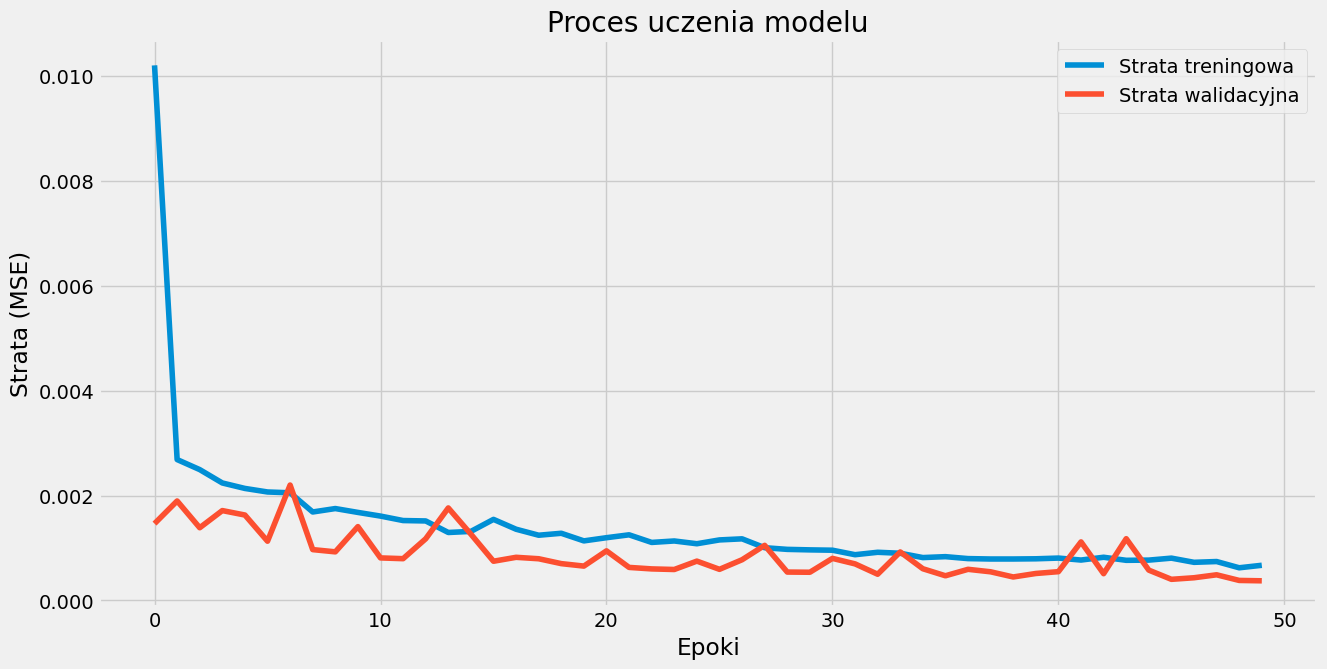

In [ ]:
# Wizualizacja procesu uczenia
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Proces uczenia modelu')
plt.xlabel('Epoki')
plt.ylabel('Strata (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 7. Ewaluacja modelu

W tej sekcji ocenimy skuteczność modelu przy użyciu różnych metryk.

In [ ]:
# Przewidywania na zbiorze testowym
predictions = model.predict(X_test)

# Odwracamy normalizację, aby uzyskać rzeczywiste wartości cen
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Obliczamy metryki
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"R² Score: {r2:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Root Mean Squared Error (RMSE): $57.47
Mean Absolute Error (MAE): $38.80
R² Score: 0.9766


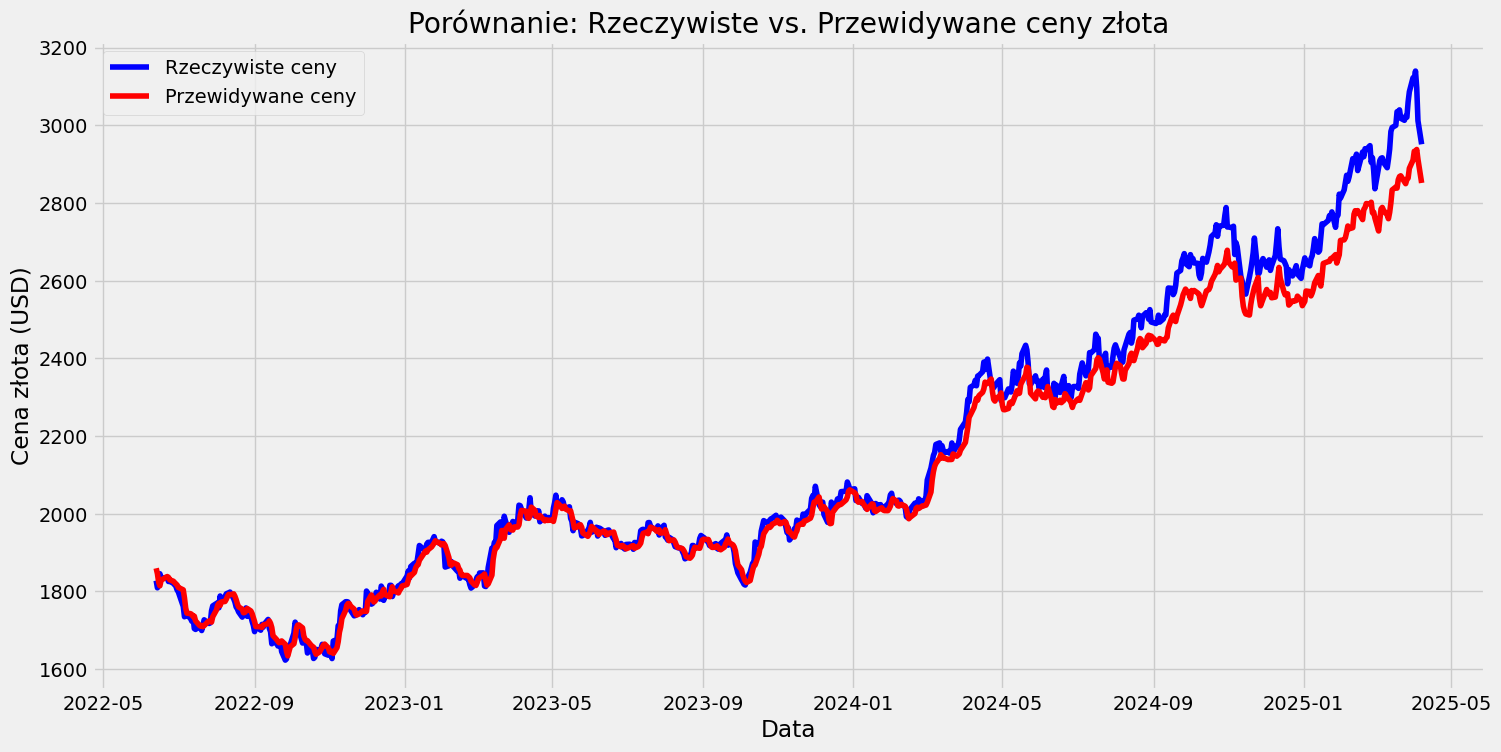

In [ ]:
# Wizualizacja rzeczywistych cen vs przewidywanych
# Tworzymy dataframe do wizualizacji
test_data = gold_data[['Close']].values[train_size+time_steps:len(dataset), :]  # Zmiana z filter() na bezpośrednie indeksowanie
actual_values = pd.DataFrame(test_data, columns=['Rzeczywista'])
predicted_values = pd.DataFrame(predictions, columns=['Przewidywana'])
comparison_df = pd.concat([actual_values, predicted_values], axis=1)

# Dodajemy daty do ramki danych
comparison_df['Date'] = gold_data['Date'][train_size+time_steps:].values

# Wykres porównawczy
plt.figure(figsize=(16, 8))
plt.title('Porównanie: Rzeczywiste vs. Przewidywane ceny złota')
plt.plot(comparison_df['Date'], comparison_df['Rzeczywista'], label='Rzeczywiste ceny', color='blue')
plt.plot(comparison_df['Date'], comparison_df['Przewidywana'], label='Przewidywane ceny', color='red')
plt.xlabel('Data')
plt.ylabel('Cena złota (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 8. Przewidywanie ceny złota

W tej sekcji wykorzystamy wytrenowany model do przewidzenia ceny złota na następny dzień.

In [ ]:
# Przygotowanie danych do przewidywania ceny na następny dzień
# Bierzemy ostatnie 60 dni danych
last_60_days = data[-60:].values

# Normalizacja
last_60_days_scaled = scaler.transform(last_60_days)

# Tworzenie sekwencji wejściowej
X_predict = np.array([last_60_days_scaled])
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

# Przewidywanie ceny na następny dzień
predicted_price_scaled = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# Wyświetlenie wyniku
today_price = gold_data['Close'].iloc[-1].item()  # Konwersja Series na skalar za pomocą .item()
predicted_price = predicted_price[0][0]

print(f"Ostatnia znana cena złota: ${today_price:.2f}")
print(f"Przewidywana cena złota na następny dzień: ${predicted_price:.2f}")
print(f"Zmiana: ${predicted_price - today_price:.2f} ({((predicted_price / today_price) - 1) * 100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Ostatnia znana cena złota: $2951.30
Przewidywana cena złota na następny dzień: $2806.74
Zmiana: $-144.56 (-4.90%)


## Podsumowanie

W tym notebooku stworzyliśmy model uczenia maszynowego oparty na sieciach LSTM do przewidywania cen złota. Pobraliśmy dane historyczne, przeprowadziliśmy analizę eksploracyjną, przygotowaliśmy dane i nauczyliśmy model. Na koniec wykorzystaliśmy model do przewidzenia ceny złota na następny dzień.

Należy pamiętać, że model ma swoje ograniczenia i nie może przewidzieć nagłych zmian spowodowanych nieoczekiwanymi wydarzeniami światowymi, decyzjami politycznymi czy makroekonomicznymi.